In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.classifiers.pytorch import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)

In [7]:
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/MNIST/FGSM/vanilla")
file = "model_01.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 98.8 %


In [9]:
accuracies = []
n = 1000

# Run test for each epsilon
for e in epsilons:
    adv_crafter = FastGradientMethod(classifier, eps=e)
    x_test_adv = adv_crafter.generate(x=x_test[:n])
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(accuracy)
    print("Epsilon: {}   Test Accuracy = {}".format(e, accuracy))
    
print(accuracies)

Epsilon: 0.01   Test Accuracy = 0.985
Epsilon: 0.1   Test Accuracy = 0.824
Epsilon: 0.2   Test Accuracy = 0.376
Epsilon: 0.3   Test Accuracy = 0.108
Epsilon: 0.4   Test Accuracy = 0.027
Epsilon: 0.5   Test Accuracy = 0.012
Epsilon: 0.6   Test Accuracy = 0.011
[0.985, 0.824, 0.376, 0.108, 0.027, 0.012, 0.011]


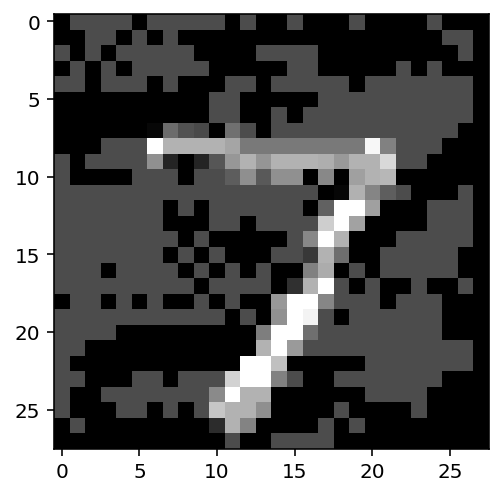

In [31]:
plt.imshow(np.swapaxes(x_test_adv[0], 2,0).squeeze(), cmap='gray')

## Results

### Vary epsilon experiment

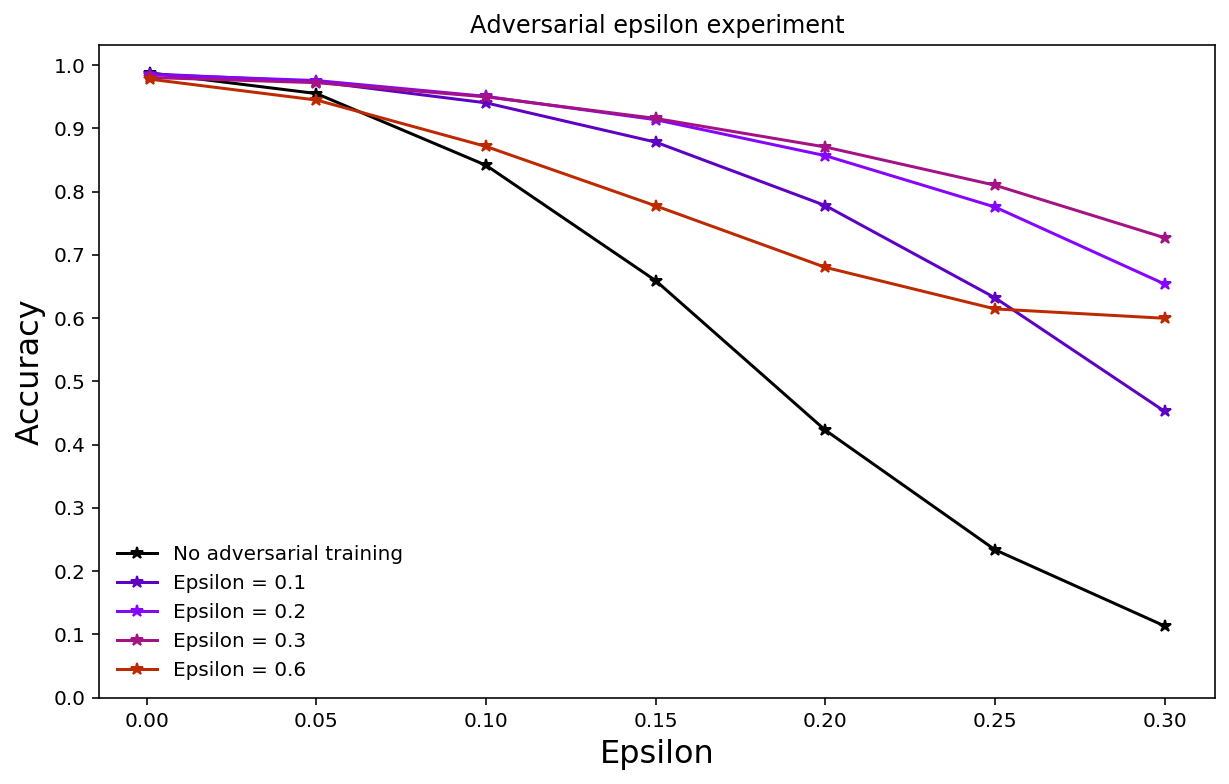

In [109]:
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
results = {
    'No adversarial training': [0.9875, 0.9549, 0.8415, 0.6591, 0.4227, 0.2337, 0.1132],
    'Epsilon = 0.1': [0.986  , 0.9738 , 0.9402 , 0.8781 , 0.77785, 0.63205, 0.45245],
    'Epsilon = 0.2': [0.9848 , 0.97545, 0.95045, 0.91355, 0.8567 , 0.7755 , 0.65375],
    'Epsilon = 0.3': [0.9803 , 0.9721 , 0.94965, 0.91555, 0.8704 , 0.81   , 0.7269 ],
    'Epsilon = 0.6': [0.9776 , 0.94465, 0.87125, 0.7774 , 0.68015, 0.61445, 0.59965],
}

n = len(results)
colors = pl.cm.gnuplot(np.linspace(0,0.55,n))

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Adversarial epsilon experiment")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()

### Vary adversarial sample experiment

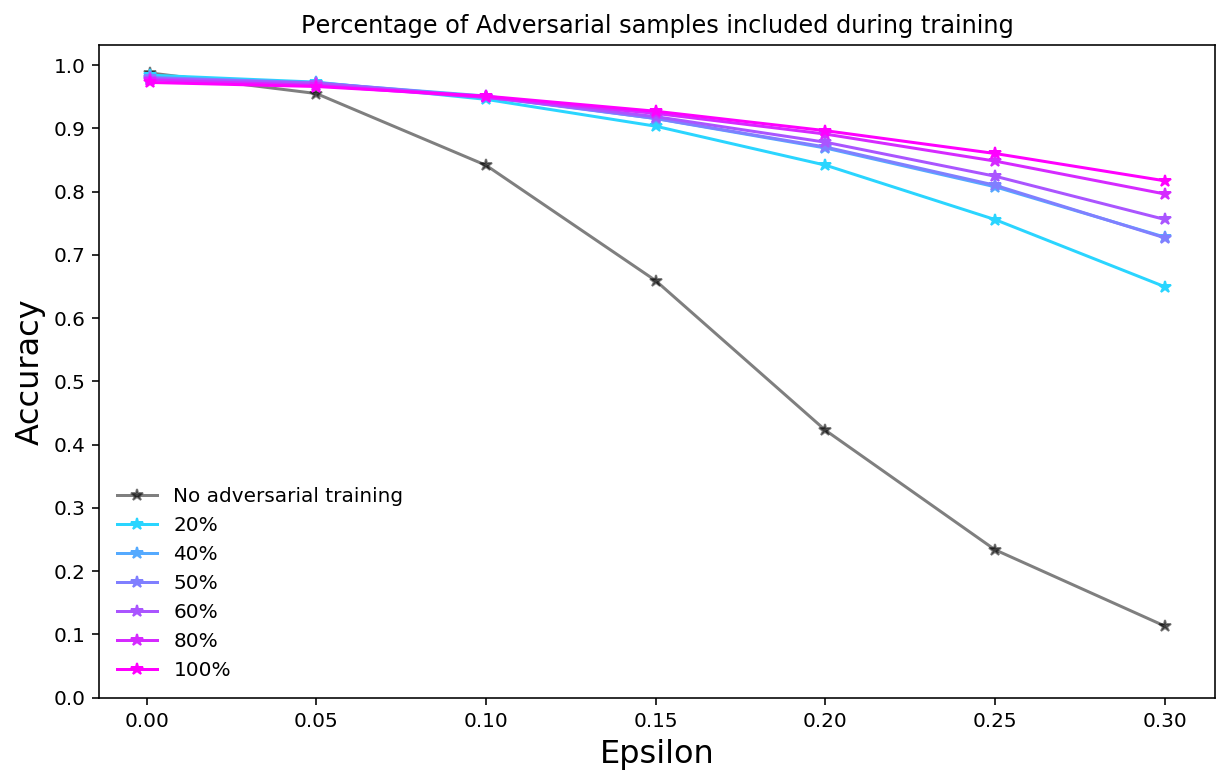

In [151]:
# data
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
results = {
    'No adversarial training': [0.9875, 0.9549, 0.8415, 0.6591, 0.4227, 0.2337, 0.1132],
    '20%': [0.98395, 0.97295, 0.94575, 0.9033 , 0.84175, 0.7557 , 0.6496 ],
    '40%': [0.9793 , 0.9715 , 0.951  , 0.91535, 0.86885, 0.80755, 0.72805],
    '50%': [0.9803 , 0.9721 , 0.94965, 0.91555, 0.8704 , 0.81   , 0.7269 ],
    '60%': [0.97845, 0.9713 , 0.94895, 0.9184 , 0.878  , 0.82425, 0.75595],
    '80%': [0.97645, 0.9678 , 0.9487 , 0.92355, 0.8909 , 0.84815, 0.7962 ],
    '100%': [0.97245, 0.96605, 0.95085, 0.92695, 0.89625, 0.86015, 0.817  ], 
}

# colors
n = len(results)
colors = pl.cm.cool(np.linspace(0,1,n))
colors[0]=[0,0,0,0.5] #half-black
# plot
plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Percentage of Adversarial samples included during training")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()

### Train benign-adversarial experiment

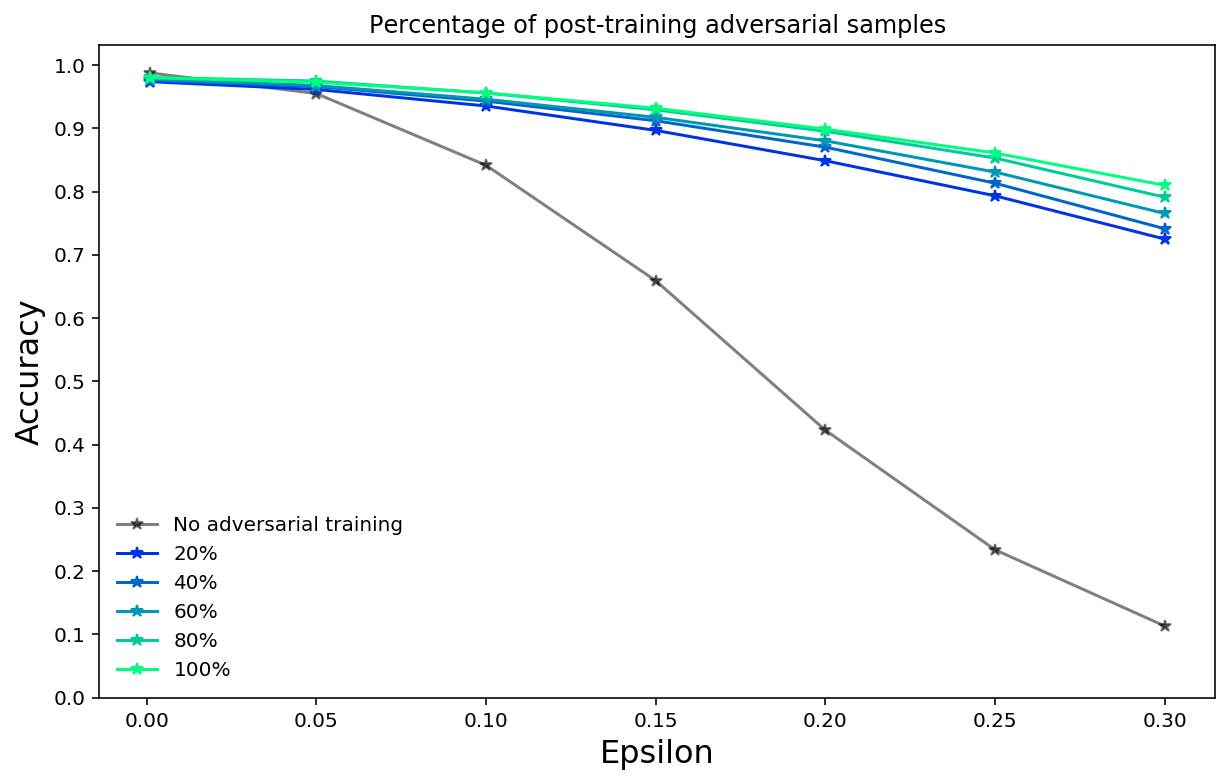

In [152]:
# data
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
results = {
    'No adversarial training': [0.9875, 0.9549, 0.8415, 0.6591, 0.4227, 0.2337, 0.1132],
    '20%': [0.97365, 0.9614 , 0.93525, 0.89665, 0.8487 , 0.7933 , 0.7249 ],
    '40%': [0.9755 , 0.96595, 0.94295, 0.91195, 0.87015, 0.8132 , 0.7412 ],
    '60%': [0.9781 , 0.9676 , 0.9459 , 0.91735, 0.8802 , 0.8308 , 0.7653 ],
    '80%': [0.98045, 0.9746 , 0.95575, 0.92925, 0.89535, 0.85295, 0.7911 ],
    '100%': [0.98005, 0.973  , 0.95595, 0.9317 , 0.89865, 0.8609 , 0.8098 ],
}

# colors
n = len(results)
colors = pl.cm.winter(np.linspace(0,1,n))
colors[0]=[0,0,0,0.5]

# plot
plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Percentage of post-training adversarial samples")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()

### Train adversarial-benign experiment

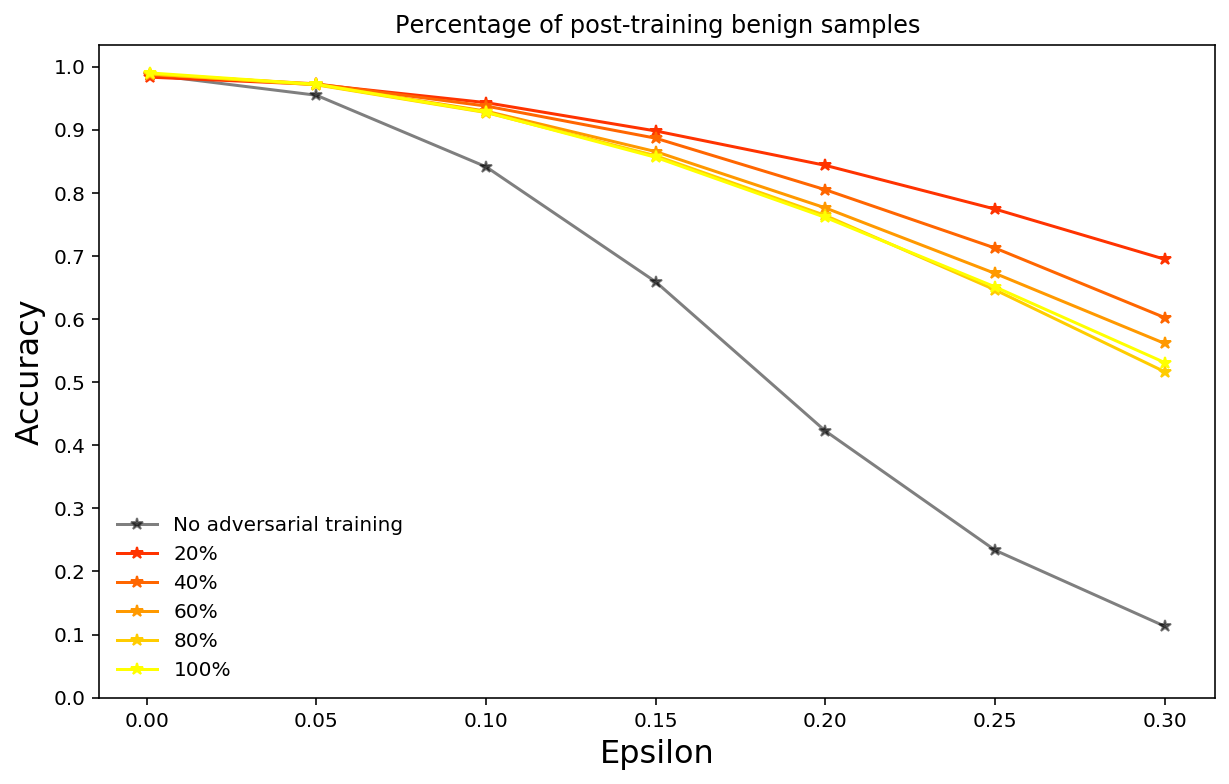

In [155]:
# data
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
results = {
    'No adversarial training': [0.9875, 0.9549, 0.8415, 0.6591, 0.4227, 0.2337, 0.1132],
    '20%': [0.98355, 0.97205, 0.9432 , 0.8983 , 0.84375, 0.77445, 0.69495],
    '40%': [0.9873 , 0.97295, 0.9378 , 0.8868 , 0.8051 , 0.7127 , 0.60245],
    '60%': [0.98865, 0.97205, 0.92965, 0.86555, 0.7763 , 0.6725 , 0.56145],
    '80%': [0.9888 , 0.97135, 0.9275 , 0.859  , 0.7643 , 0.6464 , 0.51655],
    '100%': [0.99025, 0.97225, 0.92815, 0.8565 , 0.76125, 0.6511 , 0.53115],
}

# colors
n = len(results)
colors = pl.cm.autumn(np.linspace(0,1,n))
colors[0]=[0,0,0,0.5]

# plot
plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Percentage of post-training benign samples")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()